# Food Truck Daily Assistant — **True Multi‑Agent Router** (LangGraph)

Router → specialized assistants → tool nodes loop.

## 0) Install deps

In [1]:

# If needed:
# %pip install -q langgraph>=0.2.30 langchain-core>=0.3.7 langchain-openai>=0.3.0 pydantic>=2.6.0 python-dotenv>=1.0.1 ipywidgets>=8.1.2


## 1) Imports, env, data

In [2]:

import os, json, re
from pathlib import Path
from typing import Annotated, Dict, List, Optional, Any

from dotenv import load_dotenv
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY", "").strip()
print("OPENAI_API_KEY:", "set" if api_key else "missing")
print("Model:", os.getenv("OPENAI_MODEL", "gpt-4o-mini"))

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "food_truck" / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)

MENU_PATH = DATA_DIR / "menu.json"
INV_PATH = DATA_DIR / "inventory.json"
ORDERS_PATH = DATA_DIR / "orders.json"
FEEDBACK_PATH = DATA_DIR / "feedback.json"

def _safe_read_json(path: Path, default: Any):
    try:
        if not path.exists():
            path.write_text(json.dumps(default, indent=2)); return default
        return json.loads(path.read_text())
    except Exception:
        path.write_text(json.dumps(default, indent=2)); return default

def _safe_write_json(path: Path, data: Any):
    try:
        path.write_text(json.dumps(data, indent=2)); return True
    except Exception:
        return False

DEFAULT_MENU = {"special": None, "items": {"taco": 4.5, "burrito": 7.5, "quesadilla": 6.0, "iced_tea": 2.0, "soda": 2.0}}
DEFAULT_INV = {"taco": 20, "burrito": 15, "quesadilla": 10, "iced_tea": 30, "soda": 25}

_safe_read_json(MENU_PATH, DEFAULT_MENU)
_safe_read_json(INV_PATH, DEFAULT_INV)
_safe_read_json(ORDERS_PATH, {})
_safe_read_json(FEEDBACK_PATH, [])

def _load_menu() -> dict: return _safe_read_json(MENU_PATH, DEFAULT_MENU)
def _save_menu(menu: dict) -> bool: return _safe_write_json(MENU_PATH, menu)
def _load_inv() -> dict: return _safe_read_json(INV_PATH, DEFAULT_INV)
def _save_inv(inv: dict) -> bool: return _safe_write_json(INV_PATH, inv)
def _load_orders() -> dict: return _safe_read_json(ORDERS_PATH, {})
def _save_orders(orders: dict) -> bool: return _safe_write_json(ORDERS_PATH, orders)
def _load_feedback() -> list: return _safe_read_json(FEEDBACK_PATH, [])
def _save_feedback(rows: list) -> bool: return _safe_write_json(FEEDBACK_PATH, rows)
def _normalize_item(name: str) -> str: return name.strip().lower().replace(" ", "_")


OPENAI_API_KEY: set
Model: gpt-4o-mini


## 2) Tools per agent

In [3]:
# ---- MenuAgent tools ----
@tool
def menu_get() -> dict:
    """Return the current menu dict, including today's special and item prices."""
    return {"success": True, "message": "Menu fetched.", "data": _load_menu()}

@tool
def menu_set_special(item: str) -> dict:
    """Set today's special to an existing menu item.

    Args:
        item: Name of the item to mark as today's special.
    """
    item_n = _normalize_item(item)
    menu = _load_menu()
    if item_n not in menu["items"]:
        return {"success": False, "message": f"Item '{item}' not found in menu.", "data": None}
    menu["special"] = item_n
    _save_menu(menu)
    return {"success": True, "message": f"Special set to {item_n}.", "data": menu}

@tool
def menu_update_price(item: str, new_price: float) -> dict:
    """Update the price of an existing menu item.

    Args:
        item: Item name.
        new_price: New positive price.
    """
    item_n = _normalize_item(item)
    menu = _load_menu()
    if item_n not in menu["items"]:
        return {"success": False, "message": f"Item '{item}' not in menu.", "data": None}
    p = float(new_price)
    if p <= 0:
        return {"success": False, "message": "Price must be positive.", "data": None}
    menu["items"][item_n] = round(p, 2)
    _save_menu(menu)
    return {"success": True, "message": f"Updated {item_n} to ${p:.2f}.", "data": menu}

# ---- OrderAgent tools ----
CURRENT_CART: Dict[str, int] = {}

def _cart_total(cart: Dict[str, int]) -> float:
    menu = _load_menu()
    return round(sum(menu["items"].get(n, 0.0) * q for n, q in cart.items()), 2)

@tool
def order_add_items(items: Dict[str, int]) -> dict:
    """Add items and quantities to the current cart.

    Args:
        items: Dict of {item_name: quantity}. Example: {"taco": 2, "iced_tea": 1}
    """
    if not isinstance(items, dict) or not items:
        return {"success": False, "message": "Provide a dict of {item: qty}.", "data": None}
    menu = _load_menu()
    added, skipped = {}, []
    for raw, qty in items.items():
        item = _normalize_item(raw)
        try:
            qty = int(qty)
        except Exception:
            skipped.append((item, "invalid quantity")); continue
        if qty <= 0:
            skipped.append((item, "qty must be > 0")); continue
        if item not in menu["items"]:
            skipped.append((item, "not on menu")); continue
        CURRENT_CART[item] = CURRENT_CART.get(item, 0) + qty
        added[item] = qty
    total = _cart_total(CURRENT_CART)
    msg = f"Added: {added}. Total: ${total:.2f}."
    if skipped:
        msg += f" Skipped: {skipped}."
    return {"success": True, "message": msg, "data": {"cart": CURRENT_CART, "total": total}}

@tool
def order_remove_item(item: str, qty: int = 99999) -> dict:
    """Remove up to `qty` of an item from the current cart (default removes all).

    Args:
        item: Item name.
        qty: Quantity to remove (default removes all).
    """
    item_n = _normalize_item(item)
    if item_n not in CURRENT_CART:
        return {"success": False, "message": f"{item_n} not in cart.", "data": {"cart": CURRENT_CART, "total": _cart_total(CURRENT_CART)}}
    q = int(qty)
    if q <= 0:
        return {"success": False, "message": "Qty must be > 0.", "data": {"cart": CURRENT_CART, "total": _cart_total(CURRENT_CART)}}
    if q >= CURRENT_CART[item_n]:
        del CURRENT_CART[item_n]
    else:
        CURRENT_CART[item_n] -= q
    return {"success": True, "message": "Item updated.", "data": {"cart": CURRENT_CART, "total": _cart_total(CURRENT_CART)}}

@tool
def order_summary() -> dict:
    """Return the current cart and total price."""
    return {"success": True, "message": "Cart summary.", "data": {"cart": CURRENT_CART, "total": _cart_total(CURRENT_CART)}}

@tool
def order_clear() -> dict:
    """Clear the current cart and reset total to 0."""
    CURRENT_CART.clear()
    return {"success": True, "message": "Cart cleared.", "data": {"cart": CURRENT_CART, "total": 0.0}}

# ---- SupplyAgent tools ----
@tool
def supply_get_stock(item: Optional[str] = None) -> dict:
    """Get stock for an item, or the entire inventory if item is None."""
    inv = _load_inv()
    if item is None:
        return {"success": True, "message": "Full inventory.", "data": inv}
    key = _normalize_item(item)
    if key not in inv:
        return {"success": False, "message": f"{key} not found in inventory.", "data": None}
    return {"success": True, "message": f"Stock for {key}: {inv[key]}", "data": {key: inv[key]}}

@tool
def supply_adjust_stock(item: str, delta: int) -> dict:
    """Adjust inventory for an item by `delta` (positive adds, negative subtracts).

    Args:
        item: Item name.
        delta: Integer change to apply (e.g., -2, +5).
    """
    inv = _load_inv()
    key = _normalize_item(item)
    if key not in inv:
        return {"success": False, "message": f"{key} not in inventory.", "data": None}
    newv = inv[key] + int(delta)
    if newv < 0:
        return {"success": False, "message": "Resulting stock would be negative.", "data": {key: inv[key]}}
    inv[key] = newv
    _save_inv(inv)
    return {"success": True, "message": f"Stock for {key} is now {newv}.", "data": {key: newv}}

@tool
def supply_list_low_stock(threshold: int = 5) -> dict:
    """List items whose stock is less than or equal to `threshold`.

    Args:
        threshold: Integer stock threshold (default 5).
    """
    inv = _load_inv()
    low = {k: v for k, v in inv.items() if v <= int(threshold)}
    return {"success": True, "message": f"{len(low)} low-stock items at threshold {threshold}.", "data": low}

# ---- DeliveryAgent tools ----
@tool
def delivery_place_order(name: str, method: str = "pickup") -> dict:
    """Turn the current cart into an order, deduct inventory, and assign an order_id.

    Args:
        name: Customer name.
        method: 'pickup' or 'delivery'.
    """
    method = (method or "pickup").lower().strip()
    if method not in {"pickup", "delivery"}:
        return {"success": False, "message": "method must be 'pickup' or 'delivery'.", "data": None}
    if not CURRENT_CART:
        return {"success": False, "message": "Cart is empty.", "data": None}
    inv = _load_inv()
    for item, qty in CURRENT_CART.items():
        if inv.get(item, 0) < qty:
            return {"success": False, "message": f"Insufficient stock for {item}. Available {inv.get(item,0)}.", "data": None}
    for item, qty in CURRENT_CART.items():
        inv[item] -= qty
    _save_inv(inv)
    orders = _load_orders()
    order_id = str(len(orders) + 1)
    total = _cart_total(CURRENT_CART)
    orders[order_id] = {
        "order_id": order_id, "name": name, "method": method,
        "items": dict(CURRENT_CART), "total": total,
        "status": "ready_for_pickup" if method == "pickup" else "out_for_delivery"
    }
    _save_orders(orders)
    CURRENT_CART.clear()
    return {"success": True, "message": f"Order {order_id} placed ({method}).", "data": orders[order_id]}

@tool
def delivery_status(order_id: str) -> dict:
    """Return the status and details of an existing order by id."""
    orders = _load_orders()
    od = orders.get(str(order_id))
    if not od:
        return {"success": False, "message": f"Order {order_id} not found.", "data": None}
    return {"success": True, "message": f"Status: {od['status']}", "data": od}

# ---- FeedbackAgent tools ----
@tool
def feedback_add(order_id: str, rating: int, comment: str = "") -> dict:
    """Record a rating (1–5) and optional short comment for an order.

    Args:
        order_id: String id of the order.
        rating: Integer 1..5.
        comment: Short text comment.
    """
    r = int(rating)
    if r < 1 or r > 5:
        return {"success": False, "message": "rating must be 1..5", "data": None}
    orders = _load_orders()
    if str(order_id) not in orders:
        return {"success": False, "message": f"Order {order_id} not found.", "data": None}
    rows = _load_feedback()
    rows.append({"order_id": str(order_id), "rating": r, "comment": comment})
    _save_feedback(rows)
    return {"success": True, "message": "Feedback saved.", "data": rows[-1]}

@tool
def feedback_summary() -> dict:
    """Return average rating, count, and last five feedback rows."""
    rows = _load_feedback()
    if not rows:
        return {"success": True, "message": "No feedback yet.", "data": {"avg": None, "count": 0, "recent": []}}
    avg = sum(r["rating"] for r in rows) / len(rows)
    return {"success": True, "message": f"Average {avg:.2f} over {len(rows)} ratings.", "data": {"avg": round(avg,2), "count": len(rows), "recent": rows[-5:]}}


## 3) State & model helpers

In [4]:

class AgentState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

def get_llm():
    api_key = os.getenv("OPENAI_API_KEY", "").strip()
    if not api_key: raise RuntimeError("Missing OPENAI_API_KEY.")
    model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    return ChatOpenAI(model=model, temperature=0)


## 4) Per-agent assistants

In [5]:

TOOLS_MENU = [menu_get, menu_set_special, menu_update_price]
TOOLS_ORDER = [order_add_items, order_remove_item, order_summary, order_clear]
TOOLS_SUPPLY = [supply_get_stock, supply_adjust_stock, supply_list_low_stock]
TOOLS_DELIVERY = [delivery_place_order, delivery_status]
TOOLS_FEEDBACK = [feedback_add, feedback_summary]

def assistant_menu(state: AgentState):
    llm = get_llm().bind_tools(TOOLS_MENU)
    sys = "You are MenuAgent. Handle menu lookup, specials, and price updates."
    ai = llm.invoke([SystemMessage(content=sys)] + state["messages"])
    return {"messages": [ai]}

def assistant_order(state: AgentState):
    llm = get_llm().bind_tools(TOOLS_ORDER)
    sys = "You are OrderAgent. Manage cart: add/remove items, totals, and clear."
    ai = llm.invoke([SystemMessage(content=sys)] + state["messages"])
    return {"messages": [ai]}

def assistant_supply(state: AgentState):
    llm = get_llm().bind_tools(TOOLS_SUPPLY)
    sys = "You are SupplyAgent. Handle stock queries, adjustments, and low-stock lists."
    ai = llm.invoke([SystemMessage(content=sys)] + state["messages"])
    return {"messages": [ai]}

def assistant_delivery(state: AgentState):
    llm = get_llm().bind_tools(TOOLS_DELIVERY)
    sys = "You are DeliveryAgent. Place orders (requires name + method) and report status."
    ai = llm.invoke([SystemMessage(content=sys)] + state["messages"])
    return {"messages": [ai]}

def assistant_feedback(state: AgentState):
    llm = get_llm().bind_tools(TOOLS_FEEDBACK)
    sys = "You are FeedbackAgent. Collect ratings 1–5 and show summaries."
    ai = llm.invoke([SystemMessage(content=sys)] + state["messages"])
    return {"messages": [ai]}


## 5) ToolNodes per agent

In [6]:

NODE_TOOLS = {
    "tools_menu": ToolNode(tools=TOOLS_MENU),
    "tools_order": ToolNode(tools=TOOLS_ORDER),
    "tools_supply": ToolNode(tools=TOOLS_SUPPLY),
    "tools_delivery": ToolNode(tools=TOOLS_DELIVERY),
    "tools_feedback": ToolNode(tools=TOOLS_FEEDBACK),
}


## 6) Router (heuristic or LLM)

In [7]:

ROUTER_MODE = os.getenv("ROUTER_MODE", "heuristic").lower().strip()
ROUTE_LABELS = ["menu", "order", "supply", "delivery", "feedback"]

MENU_KWS = ["menu", "special", "price", "prices", "update price"]
ORDER_KWS = ["order", "add", "remove", "cart", "total", "summary", "clear"]
SUPPLY_KWS = ["stock", "inventory", "left", "low", "restock", "threshold"]
DELIVERY_KWS = ["place", "pickup", "delivery", "deliver", "status", "order #", "order id"]
FEEDBACK_KWS = ["rate", "rating", "feedback", "review", "stars"]

def route_heuristic(text: str) -> str:
    t = text.lower(); score = {k: 0 for k in ROUTE_LABELS}
    for kw in MENU_KWS:
        if kw in t: score["menu"] += 1
    for kw in ORDER_KWS:
        if kw in t: score["order"] += 1
    for kw in SUPPLY_KWS:
        if kw in t: score["supply"] += 1
    for kw in DELIVERY_KWS:
        if kw in t: score["delivery"] += 1
    for kw in FEEDBACK_KWS:
        if kw in t: score["feedback"] += 1
    lab = max(score, key=score.get)
    return lab if score[lab] > 0 else "order"

def route_llm_call(text: str) -> str:
    llm = get_llm()
    sys = "You are a router. Return exactly one label: menu | order | supply | delivery | feedback. Only the label."
    ai = llm.invoke([SystemMessage(content=sys), HumanMessage(content=text)])
    raw = str(ai.content).strip().lower()
    for lab in ROUTE_LABELS:
        if lab in raw: return lab
    return "order"

def router_decider(state: AgentState) -> str:
    user_msgs = [m for m in state["messages"] if getattr(m, "type", "") == "human"]
    text = user_msgs[-1].content if user_msgs else ""
    return route_llm_call(text) if ROUTER_MODE == "llm" else route_heuristic(text)

def router_node(state: AgentState): return {}


## 7) Build graph

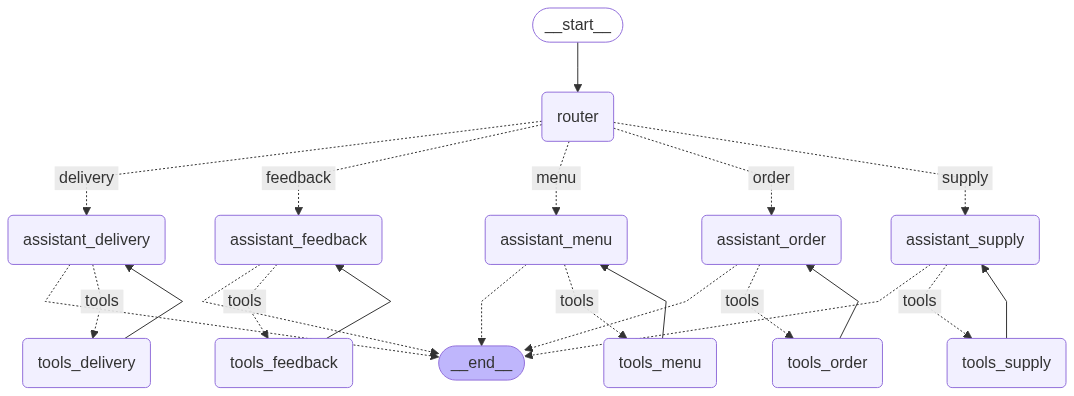

In [8]:


def build_graph():
    b = StateGraph(AgentState)
    b.add_node("router", router_node)
    b.add_conditional_edges("router", router_decider, {
        "menu": "assistant_menu",
        "order": "assistant_order",
        "supply": "assistant_supply",
        "delivery": "assistant_delivery",
        "feedback": "assistant_feedback",
    })
    b.add_node("assistant_menu", assistant_menu); b.add_node("assistant_order", assistant_order)
    b.add_node("assistant_supply", assistant_supply); b.add_node("assistant_delivery", assistant_delivery)
    b.add_node("assistant_feedback", assistant_feedback)
    for name, node in NODE_TOOLS.items(): b.add_node(name, node)
    b.add_edge(START, "router")
    b.add_conditional_edges("assistant_menu", tools_condition, {"tools": "tools_menu", "__end__": END}); b.add_edge("tools_menu", "assistant_menu")
    b.add_conditional_edges("assistant_order", tools_condition, {"tools": "tools_order", "__end__": END}); b.add_edge("tools_order", "assistant_order")
    b.add_conditional_edges("assistant_supply", tools_condition, {"tools": "tools_supply", "__end__": END}); b.add_edge("tools_supply", "assistant_supply")
    b.add_conditional_edges("assistant_delivery", tools_condition, {"tools": "tools_delivery", "__end__": END}); b.add_edge("tools_delivery", "assistant_delivery")
    b.add_conditional_edges("assistant_feedback", tools_condition, {"tools": "tools_feedback", "__end__": END}); b.add_edge("tools_feedback", "assistant_feedback")
    return b.compile()

graph = build_graph()
graph


In [9]:
state: AgentState = {"messages": []}


def chat(text: str):
    global state, graph
    state = graph.invoke({"messages": [HumanMessage(content=text)]}, state=state)
    ai = [m for m in state["messages"] if getattr(m, "type", "") == "ai"]
    print(ai[-1].content if ai else "(no response)")


## 8) Optional: ipywidgets chat UI

In [10]:
import ipywidgets as w
from IPython.display import display

def _extract_last_ai(state):
    ai = [m for m in state["messages"] if getattr(m, "type", "") == "ai"]
    if ai:
        return str(ai[-1].content)
    tool_msgs = [m for m in state["messages"] if getattr(m, "type", "") == "tool"]
    return str(tool_msgs[-1].content) if tool_msgs else "(no response)"

log = w.HTML(value="<b>Session started.</b>")
inp = w.Text(placeholder="Type your message and press Enter…", layout=w.Layout(flex="1"))

# Prefer commit-only updates (no per-keystroke events)
try:
    inp.continuous_update = False
except Exception:
    pass

send_btn  = w.Button(description="Send", button_style="primary")
reset_btn = w.Button(description="Reset State")
clear_btn = w.Button(description="Clear Log")
router    = w.Dropdown(options=["heuristic", "llm"], value=ROUTER_MODE, description="Router:")

buttons = w.HBox([send_btn, reset_btn, clear_btn, router])
bar     = w.HBox([inp])
box     = w.VBox([log, bar, buttons])
display(box)

def _send_from_text(text: str):
    """Core send handler used by both Enter and the Send button."""
    global state, graph
    text = (text or "").strip()
    if not text:
        return
    log.value += f"<div><b>You:</b> {text}</div>"
    try:
        state = graph.invoke({"messages": [HumanMessage(content=text)]}, state=state)
        reply = _extract_last_ai(state)
    except Exception as e:
        reply = f"(error) {e}"
    log.value += f"<div><b>Bot:</b> {reply}</div>"

def _on_text_commit(change):
    # With continuous_update=False, Text fires a 'value' change on Enter or blur.
    if change.get("name") == "value":
        value = (change.get("new") or "").strip()
        if value:
            _send_from_text(value)
            inp.value = ""  # clear after sending

def _click_send(_=None):
    _send_from_text(inp.value)
    inp.value = ""  # clear after sending

def _reset_state(_=None):
    global state
    state = {"messages": []}
    log.value = "<b>State reset.</b>"

def _clear_log(_=None):
    log.value = "<b>Log cleared.</b>"

def _switch_router(change):
    global ROUTER_MODE, graph
    if change.get("name") == "value" and change.get("new") in {"heuristic", "llm"}:
        ROUTER_MODE = change["new"]
        graph = build_graph()
        log.value += f"<div><i>Router set to {ROUTER_MODE}. Graph rebuilt.</i></div>"

# Wire up events (no deprecated on_submit)
inp.observe(_on_text_commit, names="value")
send_btn.on_click(_click_send)
reset_btn.on_click(_reset_state)
clear_btn.on_click(_clear_log)
router.observe(_switch_router)
